Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import GitHub repository

In [2]:
import os

if not os.path.isdir('tanogan'):
  !git clone https://github.com/sergiuabed/tanogan
else:
  %cd tanogan/
  !git pull
  %cd ..

Cloning into 'tanogan'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (26/26), done.
remote: Total 41 (delta 18), reused 34 (delta 11), pack-reused 0
Receiving objects: 100% (41/41), 8.43 KiB | 8.43 MiB/s, done.
Resolving deltas: 100% (18/18), done.


# Imports

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import pickle
import datetime
from sklearn.model_selection import train_test_split
from tanogan.data_utils.data_utils import get_df_action, get_standardizer, standardization
from tanogan.architecture import init_generator, init_discriminator, init_encoder
from tanogan.training import adversarial_training

# Load Dataset
Load dataset locally from Google Drive

In [4]:
if not os.path.isdir('csv_20220811-20220927T082743Z-001'):
  !cp -R /content/drive/MyDrive/ml-applications/TimeSeriesAnomalyDetection_project/csv_20220811-20220927T082743Z-001/ .

path = './csv_20220811-20220927T082743Z-001/csv_20220811'

# Load normal (non-anomalous) data
filepath_csv = [os.path.join(path, f"rec{r}_20220811_rbtc_0.1s.csv") for r in [0, 2, 3, 4]]
filepath_meta = [os.path.join(path, f"rec{r}_20220811_rbtc_0.1s.metadata") for r in [0, 2, 3, 4]]
df_action_regular, df_regular, df_meta_regular, action2int_regular = get_df_action(filepath_csv, filepath_meta)

# Load anomalous data
filepath_csv_rec1 = [os.path.join(path, f"rec{r}_collision_20220811_rbtc_0.1s.csv") for r in [1]]
filepath_csv_rec5 = [os.path.join(path, f"rec{r}_collision_20220811_rbtc_0.1s.csv") for r in [5]]

filepath_meta_rec1 = [os.path.join(path, f"rec{r}_collision_20220811_rbtc_0.1s.metadata") for r in [1]]
filepath_meta_rec5 = [os.path.join(path, f"rec{r}_collision_20220811_rbtc_0.1s.metadata") for r in [5]]

df_action_rec1, df_rec1, df_meta_rec1, action2int_rec1 = get_df_action(filepath_csv_rec1, filepath_meta_rec1)
df_action_rec5, df_rec5, df_meta_rec5, action2int_rec5 = get_df_action(filepath_csv_rec5, filepath_meta_rec5)

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.

Loading data.
Found 31 different actions.
Loading data done.



# Data Preprocessing

Drop some columns and standardize the data

In [5]:
# drop non-numerical columns
df_regular = df_regular.drop(["time"], axis=1)
df_rec1 = df_rec1.drop(["time"], axis=1)
df_rec5 = df_rec5.drop(["time"], axis=1)

# standardize data
standardizer = get_standardizer(df_regular)

df_regular_normal = standardization(df_regular, standardizer)
df_rec1_normal = standardization(df_rec1, standardizer)
df_rec5_normal = standardization(df_rec5, standardizer)

In [6]:
df_regular_normal.sort_index().head(2000).tail(10)

,machine_nameKuka Robot_apparent_power,machine_nameKuka Robot_current,machine_nameKuka Robot_export_reactive_energy,machine_nameKuka Robot_frequency,machine_nameKuka Robot_import_active_energy,machine_nameKuka Robot_phase_angle,machine_nameKuka Robot_power,machine_nameKuka Robot_power_factor,machine_nameKuka Robot_reactive_power,machine_nameKuka Robot_voltage,...,sensor_id4_GyroZ,sensor_id5_AccX,sensor_id5_AccY,sensor_id5_AccZ,sensor_id5_AngX,sensor_id5_AngY,sensor_id5_AngZ,sensor_id5_GyroX,sensor_id5_GyroY,sensor_id5_GyroZ
time,,,,,,,,,,,,,,,,,,,,,
2022-08-11 13:12:04.619,-1.078706,-1.941294,-1.696565,0.373132,-1.716024,0.417577,-0.830938,0.443463,2.486926,-0.435902,...,-0.700328,-0.251223,0.095296,0.078541,-0.176864,1.093616,0.517093,1.236690,-0.728666,-0.784789
2022-08-11 13:12:04.719,-1.078706,-1.941294,-1.696565,0.373132,-1.716024,0.417577,-0.830938,0.443463,2.486926,-0.435902,...,-0.700328,-0.251424,0.095296,0.078036,-0.176864,1.093995,0.516707,-0.816528,-0.728697,-0.784789
2022-08-11 13:12:04.819,-1.078706,-1.941294,-1.696565,0.373132,-1.716024,0.417577,-0.830938,0.443463,2.486926,-0.435902,...,-0.700328,-0.251223,0.095059,0.078288,-0.176263,1.094373,0.516321,-0.816497,-0.728634,-0.784789
2022-08-11 13:12:04.919,-1.078706,-1.941294,-1.696565,0.373132,-1.716024,0.417577,-0.830938,0.443463,2.486926,-0.435902,...,-0.700328,-0.251223,0.095059,0.078036,-0.176263,1.094373,0.516031,-0.816528,-0.728666,-0.784789
2022-08-11 13:12:05.019,-1.078706,-1.941294,-1.696565,0.373132,-1.716024,0.417577,-0.830938,0.443463,2.486926,-0.435902,...,1.442750,-0.253036,0.094585,0.077783,-0.176263,1.094751,0.515741,1.236628,-0.728697,-0.784789
2022-08-11 13:12:05.119,-1.078706,-1.941294,-1.696565,0.373132,-1.716024,0.417577,-0.830938,0.443463,2.486926,-0.435902,...,-0.700328,-0.250820,0.095296,0.078794,-0.176864,1.094751,0.515548,-0.816558,-0.728697,-0.784789
2022-08-11 13:12:05.219,-1.078706,-1.941294,-1.696565,0.373132,-1.716024,0.417577,-0.830938,0.443463,2.486926,-0.435902,...,-0.700328,-0.252230,0.094822,0.076771,-0.176864,1.095130,0.515259,-0.816558,-0.728697,-0.784789
2022-08-11 13:12:05.319,-1.078706,-1.941294,-1.696565,-1.284248,-1.716024,0.417577,-0.830938,0.443463,2.486926,-0.435902,...,-0.700328,-0.250820,0.094822,0.078288,-0.176263,1.095130,0.514969,-0.816558,-0.728697,-0.784789
2022-08-11 13:12:05.419,-1.078706,-1.941294,-1.696565,-1.284248,-1.716024,0.417577,-0.830938,0.443463,2.486926,-0.435902,...,-0.690812,6.040356,0.076572,0.126338,-0.164252,1.079615,0.513618,-0.815619,-0.722438,1.289187


## Read "20220811_collisions_timestamp.xlsx" and create a dataframe with a row for each anomalous time interval

In [7]:
def get_anomalous_intervals(path, sheet_names):
    # outputs dataframe with:
    #   - index: 0, 1, 2, 3, ...
    #   - columns: "start_timestamp", "end_timestamp"
    # Each row in this dataframe corresponds to a certain anomaly interval
    df_list = []
    begin_index = 0
    for sn in sheet_names:
        rec_collision_timestamps_excel = pd.read_excel(path, sheet_name=sn)

        starts = rec_collision_timestamps_excel.iloc[::2]
        starts.index = [i + begin_index for i in range(len(starts.index))]
        starts = starts.rename(columns={"Timestamp": "start_timestamp"})
        starts['start_timestamp'] = starts['start_timestamp'] - pd.Timedelta(hours=2) # anticipate 2 hours mismatch

        stops = rec_collision_timestamps_excel.iloc[1::2]
        stops.index = [i + begin_index for i in range(len(stops.index))]
        stops = stops.rename(columns={"Timestamp": "end_timestamp"})
        stops['end_timestamp'] = stops['end_timestamp'] - pd.Timedelta(hours=2) # anticipate 2 hours mismatch

        anomalous_intervals = pd.concat([starts, stops], axis=1)

        anomalous_intervals.drop('Inizio/fine', axis=1, inplace=True)
        df_list.append(anomalous_intervals)

        begin_index += len(stops.index)

    all_anomalous_intervals = pd.concat(df_list)
    return all_anomalous_intervals

anomalous_intervals = get_anomalous_intervals("./csv_20220811-20220927T082743Z-001/csv_20220811/20220811_collisions_timestamp.xlsx", ["rec1", "rec5"])

anomalous_intervals

,start_timestamp,end_timestamp
0,2022-08-11 14:02:17.450,2022-08-11 14:02:21.460
1,2022-08-11 14:02:28.320,2022-08-11 14:02:31.420
2,2022-08-11 14:02:45.770,2022-08-11 14:02:49.660
3,2022-08-11 14:02:57.490,2022-08-11 14:02:59.390
4,2022-08-11 14:03:56.960,2022-08-11 14:03:58.700
...,...,...
102,2022-08-11 17:01:56.990,2022-08-11 17:02:01.160
103,2022-08-11 17:02:11.180,2022-08-11 17:02:15.340
104,2022-08-11 17:02:58.080,2022-08-11 17:03:02.080
105,2022-08-11 17:03:44.090,2022-08-11 17:03:48.150


In [8]:
def label_timestamps(df, anomalous_intervals):

  cumulative_flag = np.array([False for d in df.index])

  for interval in anomalous_intervals.values:
    flag = np.array([(interval[0] < d and interval[1] > d) for d in df.index])
    cumulative_flag = cumulative_flag + flag  # element-wise OR operation

  df_label = df.copy()
  df_label.insert(0, "anomaly", [0 for _ in range(len(df.index))], True)
  df_label.loc[cumulative_flag.tolist(), "anomaly"] = 1

  return df_label

df_regular_labelled = label_timestamps(df_regular_normal, anomalous_intervals)
df_rec1_labelled = label_timestamps(df_rec1_normal, anomalous_intervals)
df_rec5_labelled = label_timestamps(df_rec5_normal, anomalous_intervals)

df_rec1_labelled.loc[df_rec1_labelled['anomaly']==0]

,anomaly,machine_nameKuka Robot_apparent_power,machine_nameKuka Robot_current,machine_nameKuka Robot_export_reactive_energy,machine_nameKuka Robot_frequency,machine_nameKuka Robot_import_active_energy,machine_nameKuka Robot_phase_angle,machine_nameKuka Robot_power,machine_nameKuka Robot_power_factor,machine_nameKuka Robot_reactive_power,...,sensor_id4_GyroZ,sensor_id5_AccX,sensor_id5_AccY,sensor_id5_AccZ,sensor_id5_AngX,sensor_id5_AngY,sensor_id5_AngZ,sensor_id5_GyroX,sensor_id5_GyroY,sensor_id5_GyroZ
time,,,,,,,,,,,,,,,,,,,,,
2022-08-11 14:01:34.644,0,-1.659778,-1.249082,-0.902503,0.373132,-0.903120,-2.896849,-1.879994,-3.157673,0.130060,...,-0.700328,-0.250820,0.095296,0.078288,-0.175062,1.097400,1.480228,-0.816558,-0.728697,-0.784789
2022-08-11 14:01:34.744,0,-1.659778,-1.249082,-0.902503,0.373132,-0.903120,-2.896849,-1.879994,-3.157673,0.130060,...,-0.700328,-0.251021,0.095296,0.078288,-0.175062,1.097400,1.480228,-0.816558,-0.728697,-0.784789
2022-08-11 14:01:34.844,0,-1.659778,-1.249082,-0.902503,0.373132,-0.903120,-2.896849,-1.879994,-3.157673,0.130060,...,-0.700328,-0.250820,0.095059,0.078288,-0.175062,1.097400,1.480228,-0.816558,-0.728697,-0.784789
2022-08-11 14:01:34.944,0,-1.659778,-1.249082,-0.902503,0.373132,-0.903120,-2.896849,-1.879994,-3.157673,0.130060,...,-0.700328,-0.251424,0.095770,0.078036,-0.175062,1.097400,1.480228,-0.816558,-0.728697,-0.784789
2022-08-11 14:01:35.044,0,-1.659778,-1.249082,-0.902503,0.373132,-0.903120,-2.896849,-1.879994,-3.157673,0.130060,...,-0.700328,-0.251021,0.095296,0.078036,-0.175062,1.097400,1.480228,-0.816558,-0.728697,-0.784789
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-11 14:30:30.744,0,0.967267,1.377899,-0.442150,0.373132,-0.428394,0.596178,0.911731,0.607155,-1.151908,...,1.422573,6.045191,0.125160,0.078036,-0.057356,0.761747,1.586996,1.225725,1.358975,-0.767006
2022-08-11 14:30:30.844,0,0.967267,1.377899,-0.442150,0.373132,-0.428394,0.596178,0.911731,0.607155,-1.151908,...,1.424142,-0.257468,0.109043,0.163513,-0.175062,0.964199,1.603697,1.230612,1.364754,-0.776864
2022-08-11 14:30:30.944,0,0.967267,1.377899,-0.442150,0.373132,-0.428394,0.596178,0.911731,0.607155,-1.151908,...,1.436010,-0.233696,0.079653,0.121027,-0.205690,1.047071,1.614895,1.233559,1.376755,-0.783076


# Hyperparameters

In [9]:
DATASET_FREQUENCY = 10 #Hz
WINDOW_TIME = 6 #seconds
WINDOW_SIZE = DATASET_FREQUENCY * WINDOW_TIME # nr of samples in a window
SAMPLE_SIZE = 55# df_regular_labelled.iloc[0].shape[0] - 1 # df_regular_labelled has column "anomaly", which shall not be used for training
LATENT_VAR_SIZE = 32 #SAMPLE_SIZE
TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 1
EPOCHS = 20
LAMBDA = 0.1
NR_LATENT_MAP_ITERS = 50

training_loss = tf.keras.losses.BinaryCrossentropy()
#discr_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)
#gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

discr_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)
gen_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

z_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0002) # optimizer for used for mapping to latent space


In [10]:
SAMPLE_SIZE

55

## Window the data

In [11]:
def window_data(df, window_size, shift=1): # window_size refers to the nr of samples in a window
  df.sort_index(inplace=True)
  #df.index = [i for i in range(len(df.index))]

  windows_list = []
  label_list = []

  for i in range(0, len(df.index), shift):
    if i + window_size <= len(df.index):
      window = df.iloc[i : i + window_size].copy()

      nr_anomalies = window['anomaly'].sum()

      if nr_anomalies > 0:
        #print(f"This happened! nr_anomalies={nr_anomalies}")
        label_list.append(1)
      else:
        label_list.append(0)

      window = window.drop(["anomaly"], axis=1).to_numpy()

      windows_list.append(window)
      #print(len(windows_list))

  return np.array(windows_list), np.array(label_list)
  #return windows_list, label_list



In [12]:
windows_regular, labels_regular = window_data(df_regular_labelled, WINDOW_SIZE, 1)
print()
windows_rec1, labels_rec1 = window_data(df_rec1_labelled, WINDOW_SIZE, WINDOW_SIZE)
windows_rec5, labels_rec5 = window_data(df_rec5_labelled, WINDOW_SIZE, WINDOW_SIZE)

In [ ]:
print(f"Nr samples in df_regular_labelled: {df_regular_labelled.shape}")
print(f"Nr of windows in windows_regular: {windows_regular.shape}\n")

print(f"Nr samples in df_rec1_labelled: {df_rec1_labelled.shape}")
print(f"Nr of windows in windows_rec1: {windows_rec1.shape}\n")

print(f"Nr samples in df_rec5_labelled: {df_rec5_labelled.shape}")
print(f"Nr of windows in windows_rec5: {windows_rec5.shape}\n")

print(f"Nr of anomalous windows in windows_regular: {windows_regular[labels_regular==1].shape[0]}")
print(f"Nr of anomalous windows in windows_rec1: {windows_rec1[labels_rec1==1].shape[0]}")
print(f"Nr of anomalous windows in windows_rec5: {windows_rec5[labels_rec5==1].shape[0]}")

Nr samples in df_regular_labelled: (95815, 56)
Nr of windows in windows_regular: (95756, 60, 55)

Nr samples in df_rec1_labelled: (17366, 56)
Nr of windows in windows_rec1: (289, 60, 55)

Nr samples in df_rec5_labelled: (16909, 56)
Nr of windows in windows_rec5: (281, 60, 55)

Nr of anomalous windows in windows_regular: 0
Nr of anomalous windows in windows_rec1: 53
Nr of anomalous windows in windows_rec5: 121


In [13]:
#overlapped_windows_rec1, overlapped_labels_rec1 = window_data(df_rec1_labelled, WINDOW_SIZE, 1)
#overlapped_windows_rec5, overlapped_labels_rec5 = window_data(df_rec5_labelled, WINDOW_SIZE, 1)

del df_regular, df_regular_normal, df_regular_labelled, df_rec1, df_rec1_normal, df_rec1_labelled, df_rec5, df_rec5_normal, df_rec5_labelled

# Dataset

Make TensorFlow Dataset

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((windows_regular, labels_regular)).map(lambda x, y: (tf.cast(x, tf.float32), y)).batch(TRAIN_BATCH_SIZE)
validation_dataset = tf.data.Dataset.from_tensor_slices((windows_rec5, labels_rec5)).map(lambda x, y: (tf.cast(x, tf.float32), y)).batch(TEST_BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((windows_rec1, labels_rec1)).map(lambda x, y: (tf.cast(x, tf.float32), y)).batch(TEST_BATCH_SIZE)

# Generator and Discriminator instantiation

In [ ]:
generator = init_generator(in_dim=(WINDOW_SIZE, LATENT_VAR_SIZE), out_dim=(WINDOW_SIZE, SAMPLE_SIZE))
discriminator = init_discriminator(in_dim=(WINDOW_SIZE, SAMPLE_SIZE), out_dim=1)

# Training

In [ ]:
def adversarial_training(generator, discriminator, data, batch_size, windows_size, latent_size, loss_fn, discr_optimizer, gen_optimizer, checkpoints_backup_path, num_epochs=1):

# setup checkpoint saving
  directory_path = "./checkpoints"

  filepath_generator = directory_path + "/generator/"
  filepath_discriminator = directory_path + "/discriminator/"

  if not os.path.isdir('checkpoints'):
    ! mkdir checkpoints

    ! mkdir {filepath_generator}
    ! mkdir {filepath_discriminator}

  real_label = 0
  fake_label = 1

  print("epoch: 0/%d")
  for epoch in range(num_epochs):
    for i, (time_sequences, labels) in enumerate(data):
      # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))

      #Train with real data
      with tf.GradientTape() as tape:
        scores = discriminator(time_sequences)
        discr_real_loss = loss_fn(labels, scores)

      gradients = tape.gradient(discr_real_loss, discriminator.trainable_weights)
      discr_optimizer.apply_gradients(zip(gradients, discriminator.trainable_weights))

      #Train with fake data
      noise = tf.random.normal((time_sequences.shape[0], time_sequences.shape[1], latent_size), mean=0, stddev=1)
      fake_sequences = generator(noise)
      fake_labels = tf.ones(labels.shape) * fake_label

      with tf.GradientTape() as tape:
          scores = discriminator(fake_sequences)
          discr_fake_loss = loss_fn(fake_labels, scores)

      gradients = tape.gradient(discr_fake_loss, discriminator.trainable_weights)
      discr_optimizer.apply_gradients(zip(gradients, discriminator.trainable_weights))


      # (2) Update G network: maximize log(D(G(z)))

      noise = tf.random.normal((time_sequences.shape[0], time_sequences.shape[1], latent_size), mean=0, stddev=1)
      with tf.GradientTape() as tape:
        fake_sequences = generator(noise)
        #real_labels = tf.ones(noise.shape)
        discriminator_output = discriminator(fake_sequences)    # discriminator tells which fake sequences it considers to be real and which not
        generator_loss = loss_fn(labels, discriminator_output)

      gradients = tape.gradient(generator_loss, generator.trainable_weights)
      gen_optimizer.apply_gradients(zip(gradients, generator.trainable_weights))

      print(
          f"epoch: {epoch}/{num_epochs},    batch: {i}/{len(data)}    Discriminator_loss: {discr_real_loss+discr_fake_loss}  Generator_loss: {generator_loss}"
      )

    generator.save_weights(filepath_generator + f"gen_epoch{epoch}.h5")
    discriminator.save_weights(filepath_discriminator + f"discr_epoch{epoch}.h5")

    # zip and move a copy of the checkpoints
    now = datetime.datetime.now()
    zip_name = f"checkpoints_{str(now.date())+'_'+str(now.time())}.zip"

    !zip -r {zip_name} ./checkpoints
    !cp {zip_name} {checkpoints_backup_path}


In [ ]:
adversarial_training(generator, discriminator, train_dataset, TRAIN_BATCH_SIZE, WINDOW_SIZE, LATENT_VAR_SIZE, training_loss, discr_optimizer, gen_optimizer, "./drive/MyDrive/ml-applications/TimeSeriesAnomalyDetection_project/saved_checkpoints", 20)

epoch: 0/%d


Streaming output truncated to the last 5000 lines.
epoch: 18/20,    batch: 1070/2993    Discriminator_loss: 0.0007189430762082338  Generator_loss: 8.134445190429688
epoch: 18/20,    batch: 1071/2993    Discriminator_loss: 0.00036440457915887237  Generator_loss: 8.134140014648438
epoch: 18/20,    batch: 1072/2993    Discriminator_loss: 0.0003102745395153761  Generator_loss: 8.13317584991455
epoch: 18/20,    batch: 1073/2993    Discriminator_loss: 0.0003130091936327517  Generator_loss: 8.131021499633789
epoch: 18/20,    batch: 1074/2993    Discriminator_loss: 0.0003119141038041562  Generator_loss: 8.128454208374023
epoch: 18/20,    batch: 1075/2993    Discriminator_loss: 0.00043001584708690643  Generator_loss: 8.125303268432617
epoch: 18/20,    batch: 1076/2993    Discriminator_loss: 0.0003050115774385631  Generator_loss: 8.122111320495605
epoch: 18/20,    batch: 1077/2993    Discriminator_loss: 0.0006619088817387819  Generator_loss: 8.119303703308105
epoch: 18/20,    batch: 1078/2993   

# Encoder Training

In [ ]:
def encoder_training(encoder, generator, data, latent_size, checkpoints_backup_path, num_epochs=1):
  '''
  Encoder must be trained on regular data only.

  The purpose of the encoder is to learn the inverse mapping of the generator,
  i.e. how to map a time sequence to the latent space.
  '''

  # setup checkpoint saving
  directory_path = "./encoder_checkpoints"

  if not os.path.isdir('encoder_checkpoints'):
    ! mkdir encoder_checkpoints

  loss_fn = tf.keras.losses.MeanAbsoluteError()
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002)

  print("epoch: 0/%d")
  for epoch in range(num_epochs):
    sum_loss = 0
    for i, (time_sequences, labels) in enumerate(data):
      with tf.GradientTape() as tape:
        latent_output = encoder(time_sequences)
        generated_seq = generator(latent_output)

        enc_loss = loss_fn(time_sequences, generated_seq)

      gradients = tape.gradient(enc_loss, encoder.trainable_weights)
      optimizer.apply_gradients(zip(gradients, encoder.trainable_weights))

      sum_loss += enc_loss

      print(
        f"  epoch: {epoch}/{num_epochs},    batch: {i}/{len(data)}    Encoder_loss: {enc_loss}"
      )

    print(
      f"epoch: {epoch}/{num_epochs},  Tot_epoch_loss: {sum_loss}"
    )

    encoder.save_weights(directory_path + f"/encoder_epoch{epoch}.h5")

    now = datetime.datetime.now()
    zip_name = f"encoder_checkpoints_{str(now.date())+'_'+str(now.time())}.zip"

    !zip -r {zip_name} ./encoder_checkpoints
    !cp {zip_name} {checkpoints_backup_path}

## Start Encoder Training

In [ ]:
# init encoder
encoder = init_encoder(in_dim=(WINDOW_SIZE, SAMPLE_SIZE), out_dim=(WINDOW_SIZE, LATENT_VAR_SIZE))
encoder_training(encoder, generator, train_dataset, LATENT_VAR_SIZE, "./drive/MyDrive/ml-applications/TimeSeriesAnomalyDetection_project/saved_encoder_checkpoints", num_epochs=20)

Streaming output truncated to the last 5000 lines.
  epoch: 18/20,    batch: 1031/2993    Encoder_loss: 0.6423014402389526
  epoch: 18/20,    batch: 1032/2993    Encoder_loss: 0.6078391671180725
  epoch: 18/20,    batch: 1033/2993    Encoder_loss: 0.6946399807929993
  epoch: 18/20,    batch: 1034/2993    Encoder_loss: 0.696884274482727
  epoch: 18/20,    batch: 1035/2993    Encoder_loss: 0.5799621343612671
  epoch: 18/20,    batch: 1036/2993    Encoder_loss: 0.6190717220306396
  epoch: 18/20,    batch: 1037/2993    Encoder_loss: 0.6757188439369202
  epoch: 18/20,    batch: 1038/2993    Encoder_loss: 0.6182004809379578
  epoch: 18/20,    batch: 1039/2993    Encoder_loss: 0.5950061082839966
  epoch: 18/20,    batch: 1040/2993    Encoder_loss: 0.6730180382728577
  epoch: 18/20,    batch: 1041/2993    Encoder_loss: 0.6806582808494568
  epoch: 18/20,    batch: 1042/2993    Encoder_loss: 0.610826849937439
  epoch: 18/20,    batch: 1043/2993    Encoder_loss: 0.6898585557937622
  epoch: 18/20,

# Anomaly Detection

In [ ]:
def reconstruction_loss(time_sequences, fake_sequences, discriminator, _lambda):
  '''
  This function acts as both recontruction loss function when mapping a time sequence to
  a latent variable 'z' and as anomaly score.

  This loss is the sum of 2 losses:
      - residual loss: the sum of the absolute value of the components of the difference
          between a real time sequence and a generated one by the generator

      - discrimination loss: the sum of the absolute value of the components of the difference
          between the outputs of the LSTM layer of the discriminator when the inputs
          are a real time sequence and a generated one
  '''
  residual_loss = tf.reduce_sum(abs(time_sequences - fake_sequences))

  interm_layer = discriminator.layers[0]  # LSTM layer

  features_real = interm_layer(time_sequences)
  features_fake = interm_layer(fake_sequences)

  discrimination_loss = tf.reduce_sum(abs(features_real-features_fake))

  total_loss = (1-_lambda)*residual_loss + _lambda*discrimination_loss

  return total_loss

def anomaly_score(test_data, generator, discriminator, encoder, _lambda):
  '''
  Outputs a list of losses, each loss corresponding to a time window
  '''

  # IMPORTANT: DURING ANOMALY DETECTION, SET BATCH_SIZE=1!!!!!!!!!!!!!!!!!!
  # i.e., a batch contains a single window of timesteps

  i = 0
  loss_list = []
  for _, batch in enumerate(test_data):
    print(f"batch: {i} out of {len(test_data)}")
    i+=1

    # map time sequences to latent space
    latent_var = encoder(batch[0]) # batch size is 1, so batch[0] points to the window

    # reconstruct time sequences from latent space
    reconstr_sequences = generator(latent_var)

    # compute reconstruction loss
    loss = reconstruction_loss(batch[0], reconstr_sequences, discriminator, _lambda)

    loss_list.append(loss)
  return loss_list


# Perform inference
Either use the generator and discriminator at the state you have them now (if you just trained them), or load a previously saved checkpoint

In [ ]:
generator = init_generator(in_dim=(WINDOW_SIZE, LATENT_VAR_SIZE), out_dim=(WINDOW_SIZE, SAMPLE_SIZE))
discriminator = init_discriminator(in_dim=(WINDOW_SIZE, SAMPLE_SIZE), out_dim=1)
encoder = init_encoder(in_dim=(WINDOW_SIZE, SAMPLE_SIZE), out_dim=(WINDOW_SIZE, LATENT_VAR_SIZE))

# download and uzip latest generator and discriminator checkpoints
!cp ./drive/MyDrive/ml-applications/TimeSeriesAnomalyDetection_project/saved_checkpoints/checkpoints_2023-07-26_17:42:21.134678.zip .
!unzip ./checkpoints_2023-07-26_17:42:21.134678.zip -d .

# download and unzip latest encoder checkpoint
!cp ./drive/MyDrive/ml-applications/TimeSeriesAnomalyDetection_project/saved_encoder_checkpoints/encoder_checkpoints_2023-08-10_22:37:38.628102.zip .
!unzip ./encoder_checkpoints_2023-08-10_22:37:38.628102.zip -d .

epoch = 19
generator.load_weights(f"./checkpoints/generator/gen_epoch{epoch}.h5")
discriminator.load_weights(f"./checkpoints/discriminator/discr_epoch{epoch}.h5")

epoch_enc = 19 # SET THIS TO 19 AFTER FULLY TRAINING THE ENCODER!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
encoder.load_weights(f"./encoder_checkpoints/encoder_epoch{epoch_enc}.h5")

Archive:  ./checkpoints_2023-07-26_17:42:21.134678.zip
   creating: ./checkpoints/
   creating: ./checkpoints/generator/
  inflating: ./checkpoints/generator/gen_epoch0.h5  
  inflating: ./checkpoints/generator/gen_epoch7.h5  
  inflating: ./checkpoints/generator/gen_epoch4.h5  
  inflating: ./checkpoints/generator/gen_epoch2.h5  
  inflating: ./checkpoints/generator/gen_epoch12.h5  
  inflating: ./checkpoints/generator/gen_epoch16.h5  
  inflating: ./checkpoints/generator/gen_epoch13.h5  
  inflating: ./checkpoints/generator/gen_epoch10.h5  
  inflating: ./checkpoints/generator/gen_epoch15.h5  
  inflating: ./checkpoints/generator/gen_epoch19.h5  
  inflating: ./checkpoints/generator/gen_epoch8.h5  
  inflating: ./checkpoints/generator/gen_epoch11.h5  
  inflating: ./checkpoints/generator/gen_epoch18.h5  
  inflating: ./checkpoints/generator/gen_epoch14.h5  
  inflating: ./checkpoints/generator/gen_epoch1.h5  
  inflating: ./checkpoints/generator/gen_epoch6.h5  
  inflating: ./checkpo

In [ ]:
test_loss_list = anomaly_score(test_dataset, generator, discriminator, encoder, LAMBDA)

batch: 0 out of 289
batch: 1 out of 289
batch: 2 out of 289
batch: 3 out of 289
batch: 4 out of 289
batch: 5 out of 289
batch: 6 out of 289
batch: 7 out of 289
batch: 8 out of 289
batch: 9 out of 289
batch: 10 out of 289
batch: 11 out of 289
batch: 12 out of 289
batch: 13 out of 289
batch: 14 out of 289
batch: 15 out of 289
batch: 16 out of 289
batch: 17 out of 289
batch: 18 out of 289
batch: 19 out of 289
batch: 20 out of 289
batch: 21 out of 289
batch: 22 out of 289
batch: 23 out of 289
batch: 24 out of 289
batch: 25 out of 289
batch: 26 out of 289
batch: 27 out of 289
batch: 28 out of 289
batch: 29 out of 289
batch: 30 out of 289
batch: 31 out of 289
batch: 32 out of 289
batch: 33 out of 289
batch: 34 out of 289
batch: 35 out of 289
batch: 36 out of 289
batch: 37 out of 289
batch: 38 out of 289
batch: 39 out of 289
batch: 40 out of 289
batch: 41 out of 289
batch: 42 out of 289
batch: 43 out of 289
batch: 44 out of 289
batch: 45 out of 289
batch: 46 out of 289
batch: 47 out of 289
ba

In [ ]:
validation_loss_list = anomaly_score(validation_dataset, generator, discriminator, encoder, LAMBDA)

batch: 0 out of 281
batch: 1 out of 281
batch: 2 out of 281
batch: 3 out of 281
batch: 4 out of 281
batch: 5 out of 281
batch: 6 out of 281
batch: 7 out of 281
batch: 8 out of 281
batch: 9 out of 281
batch: 10 out of 281
batch: 11 out of 281
batch: 12 out of 281
batch: 13 out of 281
batch: 14 out of 281
batch: 15 out of 281
batch: 16 out of 281
batch: 17 out of 281
batch: 18 out of 281
batch: 19 out of 281
batch: 20 out of 281
batch: 21 out of 281
batch: 22 out of 281
batch: 23 out of 281
batch: 24 out of 281
batch: 25 out of 281
batch: 26 out of 281
batch: 27 out of 281
batch: 28 out of 281
batch: 29 out of 281
batch: 30 out of 281
batch: 31 out of 281
batch: 32 out of 281
batch: 33 out of 281
batch: 34 out of 281
batch: 35 out of 281
batch: 36 out of 281
batch: 37 out of 281
batch: 38 out of 281
batch: 39 out of 281
batch: 40 out of 281
batch: 41 out of 281
batch: 42 out of 281
batch: 43 out of 281
batch: 44 out of 281
batch: 45 out of 281
batch: 46 out of 281
batch: 47 out of 281
ba

## Save in Drive the losses obtained on test or validation datasets

In [ ]:
test_loss_array = np.array([i.numpy().item() for i in test_loss_list])

with open('test_loss.npy', 'wb') as f:
  np.save(f, test_loss_array)

!cp ./test_loss.npy ./drive/MyDrive/ml-applications/TimeSeriesAnomalyDetection_project/saved_losses_modifiedModel/

array([1936.99621582, 1955.69384766, 1930.90209961, 1932.89746094,
       2296.17285156, 2185.13256836, 2015.30444336, 2509.19726562,
       1978.28271484, 2326.88330078, 1857.4654541 , 2274.29516602,
       2446.6262207 , 2046.8236084 , 2132.75341797, 1965.10693359,
       2196.20654297, 2118.03320312, 1943.59301758, 2256.95166016,
       2134.10327148, 2197.70336914, 2117.75610352, 1880.02807617,
       2241.06958008, 1955.47265625, 2163.00756836, 1902.93859863,
       2163.12402344, 1838.88867188, 2328.37084961, 1868.06726074,
       2106.55541992, 1815.25842285, 2188.58081055, 1785.99438477,
       2010.22766113, 1597.91601562, 2492.53393555, 1980.27990723,
       2186.93261719, 1895.11279297, 1958.0546875 , 2146.29541016,
       1854.12890625, 1971.07763672, 2212.76977539, 1705.37072754,
       2163.99145508, 1704.4519043 , 2175.80688477, 1890.5020752 ,
       2206.47094727, 2054.70410156, 2017.85913086, 1992.05419922,
       1995.0847168 , 2144.78369141, 1990.26269531, 2092.07421

# Compute and plot performance measures

In [14]:
from sklearn.metrics import f1_score, precision_score, recall_score

#!cp ./drive/MyDrive/ml-applications/TimeSeriesAnomalyDetection_project/saved_losses/test_loss.npy .

def compute_f1_score(anomaly_scores, ground_truth, thresholds):
    f1_dict = {}

    for t in thresholds:
        assigned_labels = [0 if i < t else 1 for i in anomaly_scores]
        f1_dict[t] = f1_score(ground_truth, assigned_labels)

    return f1_dict

def compute_precision_score(anomaly_scores, ground_truth, thresholds):
    precision_dict = {}

    for t in thresholds:
        assigned_labels = [0 if i < t else 1 for i in anomaly_scores]
        precision_dict[t] = precision_score(ground_truth, assigned_labels)

    return precision_dict

def compute_recall_score(anomaly_scores, ground_truth, thresholds):
    recall_dict = {}

    for t in thresholds:
        assigned_labels = [0 if i < t else 1 for i in anomaly_scores]
        recall_dict[t] = recall_score(ground_truth, assigned_labels)

    return recall_dict

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

def plot_metric(metric_results_dict, chosen_th, model_name, x_axis_descr, y_axis_descr):

  plt.figure().set_facecolor("w")
  plt.style.use('default')

  plt.title(model_name)
  plt.xlabel(x_axis_descr)
  plt.ylabel(y_axis_descr)

  plt.plot(metric_results_dict.keys(), metric_results_dict.values(), '-s', linewidth=1, markersize=2)

  plt.plot(chosen_th, metric_results_dict[chosen_th], '-o', markersize=6, color='orange',
           label='Score: {:.2f} @ chosen threshold={:.2f}'.format(metric_results_dict[chosen_th], chosen_th))

  plt.legend()
  plt.show()

def compute_metrics(anomaly_scores, ground_truth, model_name, num_thresholds=10):

  min_threshold = anomaly_scores.min()
  max_threshold = anomaly_scores.max()

  thresholds = np.linspace(start=min_threshold, stop=max_threshold, num=num_thresholds)

  print("\nF1 score")
  f1_res = compute_f1_score(anomaly_scores, ground_truth, thresholds)
  for i in f1_res.keys():
      print(f"{i}: {f1_res[i]}")

  maxval = 0
  chosen_th = 0
  for k in f1_res.keys():
    if f1_res[k] > maxval:
      maxval = f1_res[k]
      chosen_th = k

  plot_metric(f1_res, chosen_th, model_name, "threshold", "F1 score")

  print("\nPrecision score:")
  precision_res = compute_precision_score(anomaly_scores, ground_truth, thresholds)
  for i in precision_res.keys():
      print(f"{i}: {precision_res[i]}")

  plot_metric(precision_res, chosen_th, model_name, "threshold", "Precision score")

  print("\nRecall score:")
  recall_res = compute_recall_score(anomaly_scores, ground_truth, thresholds)
  for i in recall_res.keys():
    print(f"{i}: {recall_res[i]}")

  plot_metric(recall_res, chosen_th, model_name, "threshold", "Recall score")

## Load previously computed losses

In [16]:
!cp ./drive/MyDrive/ml-applications/TimeSeriesAnomalyDetection_project/saved_losses_modifiedModel/test_loss.npy .
!cp ./drive/MyDrive/ml-applications/TimeSeriesAnomalyDetection_project/saved_losses_modifiedModel/validation_loss.npy .

with open('test_loss.npy', 'rb') as f:
  test_loss = np.load(f)

with open('validation_loss.npy', 'rb') as g:
  validation_loss = np.load(g)

In [ ]:
#overlapped_windows_rec1, overlapped_labels_rec1 = window_data(df_rec1_labelled, WINDOW_SIZE, 1)
#overlapped_windows_rec5, overlapped_labels_rec5 = window_data(df_rec5_labelled, WINDOW_SIZE, 1)


F1 score
1549.2977294921875: 0.4667145486376083
1652.223920549665: 0.46835528842894913
1755.150111607143: 0.47881672265770814
1858.0763026646205: 0.5030278764826586
1961.0024937220983: 0.5367074210975263
2063.9286847795756: 0.5878741366078281
2166.8548758370534: 0.6222260673962884
2269.7810668945312: 0.624668219489735
2372.707257952009: 0.5286839145106862
2475.633449009487: 0.34148658275943955
2578.559640066964: 0.135067264573991
2681.485831124442: 0.03626404759656247
2784.4120221819194: 0.00422305403589596
2887.338213239397: 0.002305696992986838
2990.264404296875: 0.00019234468166955183


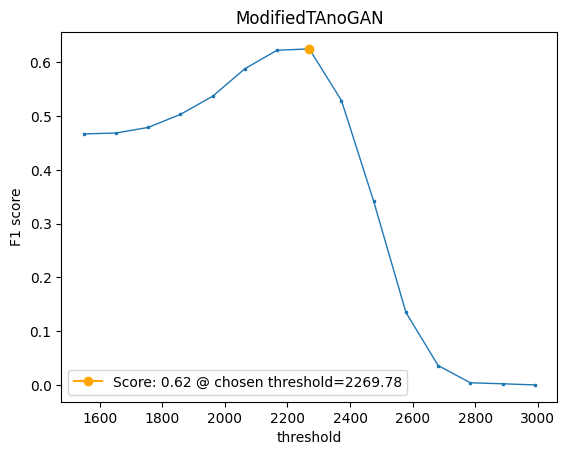


Precision score:
1549.2977294921875: 0.3043885587141728
1652.223920549665: 0.3060838747784997
1755.150111607143: 0.31607478362645147
1858.0763026646205: 0.3399627938440724
1961.0024937220983: 0.3809792919710976
2063.9286847795756: 0.4612184574963052
2166.8548758370534: 0.5654088050314465
2269.7810668945312: 0.7150297619047619
2372.707257952009: 0.8471162001696353
2475.633449009487: 0.9646690518783542
2578.559640066964: 1.0
2681.485831124442: 1.0
2784.4120221819194: 1.0
2887.338213239397: 1.0
2990.264404296875: 1.0


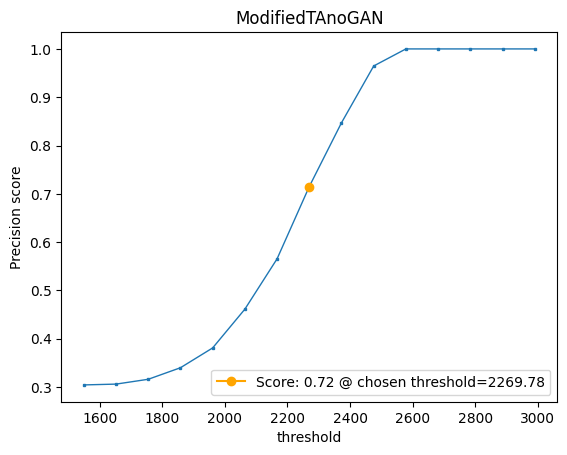


Recall score:
1549.2977294921875: 1.0
1652.223920549665: 0.9968260075021641
1755.150111607143: 0.9870154852361258
1858.0763026646205: 0.9667211695681447
1961.0024937220983: 0.9077618543810715
2063.9286847795756: 0.8104260844474368
2166.8548758370534: 0.6917380013465423
2269.7810668945312: 0.5545830528036934
2372.707257952009: 0.3842454554198326
2475.633449009487: 0.20746369144945656
2578.559640066964: 0.07242473790516495
2681.485831124442: 0.01846686544195441
2784.4120221819194: 0.0021159949985572763
2887.338213239397: 0.0011541790901221506
2990.264404296875: 9.618159084351255e-05


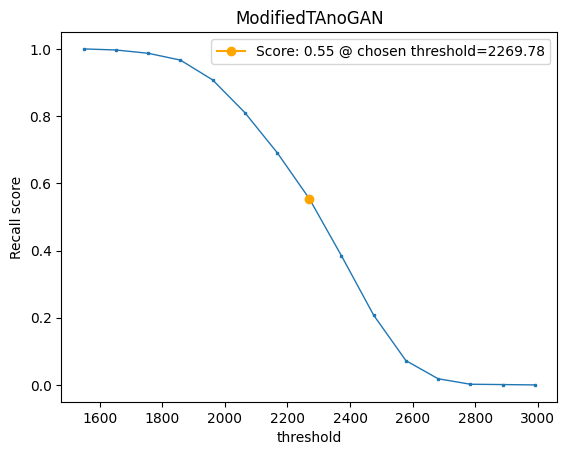

In [20]:
losses = np.concatenate((test_loss, validation_loss))
labels = np.concatenate((overlapped_labels_rec1, overlapped_labels_rec5))

compute_metrics(losses, labels, "ModifiedTAnoGAN", num_thresholds=15)

### ROC plot

In [ ]:
def roc_plot(losses, labels, plot_title, num_thresholds=10):
  min_threshold = losses.min()
  max_threshold = losses.max()

  thresholds = np.linspace(start=min_threshold, stop=max_threshold, num=15)

  sens = list()
  fpr = list()
  for threshold in thresholds:
    predicted_labels = (losses >= threshold).astype(int)  # losses above threshold are predicted as anomaly

    matching = (predicted_labels == labels).astype(int)
    tp = matching[predicted_labels==1].astype(int).sum()

    cm_anomaly = np.zeros((2, 2))
    n_samples = len(losses)
    n_not_collisions = n_samples - sum(labels)
    n_detected = sum(predicted_labels)

    fp = n_detected - tp
    fn = sum(labels) - tp
    tn = n_not_collisions - fp

    sens.append(tp / (tp + fn))
    fpr.append(1-tn /(fp + tn))

  fig, ax = plt.subplots(1, 1)
  ax.plot(fpr, sens)
  plt.title(plot_title)

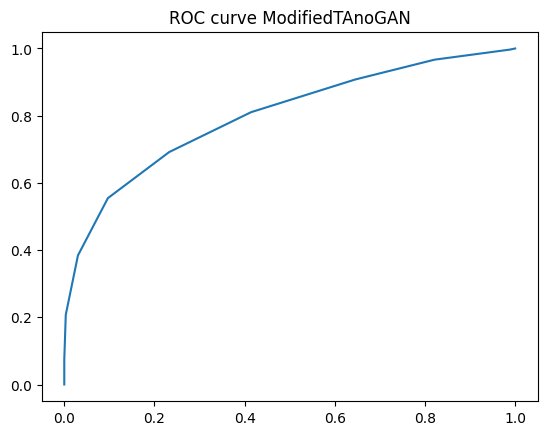

In [ ]:
roc_plot(losses, labels, "ROC curve ModifiedTAnoGAN", 15)

In [ ]:
test_loss_array = np.array([i.numpy().item() for i in test_loss_list])
test_ground_truth = labels_rec1

validation_loss_array = np.array([i.numpy().item() for i in validation_loss_list])
validation_ground_truth = labels_rec5

print("Test set metrics:")
compute_metrics(test_loss_array, test_ground_truth, num_thresholds=15)
print("\nValidation set metrics:")
compute_metrics(validation_loss_array, validation_ground_truth, num_thresholds=15)

Test set metrics:

F1 score
1577.239990234375: 0.3099415204678363
1653.994838169643: 0.3035714285714286
1730.7496861049108: 0.30434782608695654
1807.5045340401787: 0.33108108108108103
1884.2593819754466: 0.3671875
1961.0142299107142: 0.39622641509433965
2037.769077845982: 0.3902439024390244
2114.52392578125: 0.45871559633027525
2191.278773716518: 0.3846153846153846
2268.033621651786: 0.34285714285714286
2344.7884695870534: 0.2033898305084746
2421.5433175223216: 0.1724137931034483
2498.298165457589: 0.037037037037037035
2575.0530133928573: 0.037037037037037035
2651.807861328125: 0.037037037037037035

Precision score:
1577.239990234375: 0.18339100346020762
1653.994838169643: 0.18021201413427562
1730.7496861049108: 0.1821561338289963
1807.5045340401787: 0.20164609053497942
1884.2593819754466: 0.2315270935960591
1961.0142299107142: 0.2641509433962264
2037.769077845982: 0.2882882882882883
2114.52392578125: 0.44642857142857145
2191.278773716518: 0.6
2268.033621651786: 0.7058823529411765
2344

Here, we tested the performance of the model on overlapping windows. We did not notice any difference in performance results between a test dataset consisting of overlapping windows and one of non-overlapping windows.

In [ ]:
##overlapped_windows_rec1, overlapped_labels_rec1 = window_data(df_rec1_labelled, WINDOW_SIZE, 1)
##overlapped_windows_rec5, overlapped_labels_rec5 = window_data(df_rec5_labelled, WINDOW_SIZE, 1)
#
#overlapped_validation_dataset = tf.data.Dataset.from_tensor_slices((overlapped_windows_rec5, overlapped_labels_rec5)).map(lambda x, y: (tf.cast(x, tf.float32), y)).batch(TEST_BATCH_SIZE)
#overlapped_test_dataset = tf.data.Dataset.from_tensor_slices((overlapped_windows_rec1, overlapped_labels_rec1)).map(lambda x, y: (tf.cast(x, tf.float32), y)).batch(TEST_BATCH_SIZE)
#
#test_loss_list = anomaly_score(overlapped_test_dataset, generator, discriminator, encoder, LAMBDA)
#print()
#validation_loss_list = anomaly_score(overlapped_validation_dataset, generator, discriminator, encoder, LAMBDA)
#
test_loss_array = np.array([i.numpy().item() for i in test_loss_list])
test_ground_truth = overlapped_labels_rec1

validation_loss_array = np.array([i.numpy().item() for i in validation_loss_list])
validation_ground_truth = overlapped_labels_rec5

print("Test set metrics:")
compute_metrics(test_loss_array, test_ground_truth, num_thresholds=15)
print("\nValidation set metrics:")
compute_metrics(validation_loss_array, validation_ground_truth, num_thresholds=15)

Test set metrics:

F1 score
1549.2977294921875: 0.31733994458217873
1628.6830444335938: 0.3178723612675711
1708.068359375: 0.3237717424473604
1787.4536743164062: 0.33979675913210655
1866.8389892578125: 0.36508927456611306
1946.2243041992188: 0.39020346646571213
2025.609619140625: 0.40089043747580333
2104.9949340820312: 0.4010064892067276
2184.3802490234375: 0.366304347826087
2263.7655639648438: 0.2956186807896004
2343.15087890625: 0.17206085753803596
2422.5361938476562: 0.09106728538283064
2501.9215087890625: 0.04304932735426009
2581.3068237304688: 0.012180267965895249
2660.692138671875: 0.0006125574272588055

Precision score:
1549.2977294921875: 0.18859421043508406
1628.6830444335938: 0.18917973532326707
1708.068359375: 0.19410903768752286
1787.4536743164062: 0.20701425607389062
1866.8389892578125: 0.22926140818566723
1946.2243041992188: 0.25874475314811113
2025.609619140625: 0.29301075268817206
2104.9949340820312: 0.35316071845113134
2184.3802490234375: 0.44813829787234044
2263.76556

In [ ]:
with open('test_loss.npy', 'wb') as f:
  np.save(f, test_loss_array)

!cp ./test_loss.npy ./drive/MyDrive/ml-applications/TimeSeriesAnomalyDetection_project/saved_losses_modifiedModel/

with open('validation_loss.npy', 'wb') as f:
  np.save(f, validation_loss_array)

!cp ./validation_loss.npy ./drive/MyDrive/ml-applications/TimeSeriesAnomalyDetection_project/saved_losses_modifiedModel/